In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random

class VAE(nn.Module):
    def __init__(self, fcd, ld, matsz, rank):
        super(VAE, self).__init__()
        self.fcd = fcd
        self.ld = ld
        self.matsz = matsz
        self.rank = rank
        self.enc1 = nn.Linear(fcd, 1000).float().cuda()
        self.enc2 = nn.Linear(1000, ld).float().cuda()
        self.dec1 = nn.Linear(ld+6, 1000).float().cuda()
        self.dec2 = nn.Linear(1000, matsz*rank).float().cuda()

    def enc(self, x):
        x = F.relu(self.enc1(x))
        z = self.enc2(x)
        return z

    def gen(self, n):
        return torch.randn(n, self.ld).float().cuda()/(10**0.5)

    def dec(self, z, age, sex, race, rest, nback, emoid):
        z = torch.cat([z, age.unsqueeze(1), sex.unsqueeze(1), race.unsqueeze(1), 
                       rest.unsqueeze(1), nback.unsqueeze(1), emoid.unsqueeze(1)], dim=1)
        x = F.relu(self.dec1(z))
        x = self.dec2(x)
        x = x.reshape(len(z), self.matsz, self.rank)
        x = torch.einsum('abc,adc->abd', x, x)
        return x

    def vectorize(self, x):
        a,b = np.triu_indices(self.matsz, 1)
        return x[:,a,b]

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

vae = VAE(34716, 30, 264, 5)
vae.load_state_dict(torch.load('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/vae_1000_z30_cov6_264_rank5.torch'))
vae.eval()

print('Done')

Done


In [155]:
vae_dct = dict(ld=30, rois=264, rank=5, inv_sigma=10**0.5)
vae_dct['enc1_w'] = vae.enc1.weight.T.detach().cpu().numpy()
vae_dct['enc1_b'] = vae.enc1.bias.detach().cpu().numpy()
vae_dct['enc2_w'] = vae.enc2.weight.T.detach().cpu().numpy()
vae_dct['enc2_b'] = vae.enc2.bias.detach().cpu().numpy()
vae_dct['dec1_w'] = vae.dec1.weight.T.detach().cpu().numpy()
vae_dct['dec1_b'] = vae.dec1.bias.detach().cpu().numpy()
vae_dct['dec2_w'] = vae.dec2.weight.T.detach().cpu().numpy()
vae_dct['dec2_b'] = vae.dec2.bias.detach().cpu().numpy()

pickle.dump(vae_dct, open('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/vae_1000_z30_cov6_264_rank5.pkl', 'wb'))

print('Complete')

Complete


In [2]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [3]:
# Load FC

import pickle
import numpy as np

pncdir = '/home/anton/Documents/Tulane/Research/data-sav/anton/cohorts/PNC/'
lowrankdir = '/home/anton/Documents/Tulane/Research/Work/ContrastiveLearning/PNC/Top10/'
pncdemo = pickle.load(open(f'{pncdir}/demographics.pkl', 'rb'))
no_snps_subs = pickle.load(open('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/fc_subs_no_snps.pkl', 'rb'))

rest = []
nback = []
emoid = []
restmat = []
nbackmat = []
emoidmat = []
race = []
sex = []
age = []
subids = []

a,b = np.triu_indices(264,1)

for sub in pncdemo['age_at_cnb']:
    if sub in no_snps_subs:
        continue
    try:
        ra = pncdemo['Race'][sub]
        ag = pncdemo['age_at_cnb'][sub]
        se = pncdemo['Sex'][sub]
        if ra not in ['AA', 'EA']:
            continue
        ra = ra == 'AA'
        se = se == 'M'
        r = np.load(f'{lowrankdir}/{sub}_task-resttop10_fc.npy')
        n = np.load(f'{lowrankdir}/{sub}_task-nbacktop10_fc.npy')
        e = np.load(f'{lowrankdir}/{sub}_task-emoidtop10_fc.npy')
        r = remap(vec2mat(r))
        n = remap(vec2mat(n))
        e = remap(vec2mat(e))
        race.append(ra)
        sex.append(se)
        age.append(ag)
        rest.append(r[a,b])
        nback.append(n[a,b])
        emoid.append(e[a,b])
        restmat.append(r)
        nbackmat.append(n)
        emoidmat.append(e)
        subids.append(sub)
    except:
        pass

rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
restmat = np.stack(restmat)
nbackmat = np.stack(nbackmat)
emoidmat = np.stack(emoidmat)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
age = np.array(age)

print([a.shape for a in [rest, nback, emoid, restmat, nbackmat, emoidmat, race, sex, age]])

[(1155, 34716), (1155, 34716), (1155, 34716), (1155, 264, 264), (1155, 264, 264), (1155, 264, 264), (1155,), (1155,), (1155,)]


In [4]:
# Load small SNPs

snps = []
no_snps_subs = []

snps_file = pickle.load(open('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/snps_all_subs_small.pkl', 'rb'))

for sub in subids:
    if sub not in snps_file:
        print(sub)
        # no_snps_subs.append(sub)
    snps.append(snps_file[sub])

snps = np.stack(snps)
snps[np.isnan(snps)] = 0

print(snps.shape)

(1155, 10433)


In [5]:
class SNPVAE(nn.Module):
    def __init__(self, snpd, ld):
        super(SNPVAE, self).__init__()
        self.enc1 = nn.Linear(snpd*3, 1000).float().cuda()
        self.enc2 = nn.Linear(1000, ld).float().cuda()
        self.dec1 = nn.Linear(ld+2, 1000).float().cuda()
        self.dec20 = nn.Linear(1000, snpd).float().cuda()
        self.dec21 = nn.Linear(1000, snpd).float().cuda()
        self.dec22 = nn.Linear(1000, snpd).float().cuda()

    def enc(self, x):
        x = F.relu(self.enc1(x))
        z = self.enc2(x)
        return z

    def dec(self, z, sex, race):
        z = torch.cat([z, sex.unsqueeze(1), race.unsqueeze(1)], dim=1)
        x = F.relu(self.dec1(z))
        x0 = self.dec20(x)
        x1 = self.dec21(x)
        x2 = self.dec22(x)
        return torch.stack([x0, x1, x2], dim=1)

def latent_loss(z):
    C = z.T@z
    mu = torch.mean(z, dim=0)
    tgt1 = torch.eye(z.shape[-1]).float().cuda()*len(z)/10
    tgt2 = torch.zeros(z.shape[-1]).float().cuda()
    lossC = rmse(C, tgt1)
    lossmu = rmse(mu, tgt2)
    return lossC, lossmu, C, mu

def decor_loss(z, sex, race):
    sex = sex - torch.mean(sex)
    race = race - torch.mean(race)
    sexp = torch.einsum('n,nz->z', sex, z)
    racep = torch.einsum('n,nz->z', race, z)
    tgt = torch.zeros(z.shape[-1]).float().cuda()
    loss_sex = rmse(sexp, tgt)
    loss_race = rmse(racep, tgt)
    return loss_sex + loss_race

ce = nn.CrossEntropyLoss()

snpvae = SNPVAE(10433, 30)
optim = torch.optim.Adam(snpvae.parameters(), lr=1e-4, weight_decay=0)

xclass = torch.from_numpy(snps).long().cuda()
x = torch.cat([xclass == 0, xclass == 1, xclass == 2], dim=1).float().cuda()
sex_t = torch.from_numpy(sex).float().cuda()
race_t = torch.from_numpy(race).float().cuda()

nepochs = 1000
pperiod = 10

for e in range(nepochs):
    optim.zero_grad()
    z = snpvae.enc(x)
    logits = snpvae.dec(z, sex_t, race_t)
    loss_ce = ce(logits, xclass)
    loss_C, loss_mu, _, _ = latent_loss(z)
    loss_decor = decor_loss(z, sex_t, race_t)
    (loss_ce+loss_C+loss_mu+loss_decor).backward()
    # No generative loss because all we would predict are age (no SNP info), sex, race, and task
    optim.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(loss_ce)} {pretty(loss_C)} {pretty(loss_mu)} {pretty(loss_decor)}')

print('Done')

0 1.0997 22.3524 0.1137 13.4994
10 1.0721 20.984 0.0841 8.4396
20 1.0467 20.6921 0.0643 2.218
30 1.0218 20.7022 0.0508 0.7075
40 0.9968 20.7022 0.0525 0.4597
50 0.9721 20.6945 0.0581 0.2692
60 0.9493 20.6947 0.0576 0.4622
70 0.9285 20.6968 0.0558 0.3189
80 0.9093 20.6967 0.0563 0.3852
90 0.8921 20.6961 0.0569 0.3503
100 0.8772 20.696 0.0567 0.2701
110 0.8643 20.6957 0.0565 0.6752
120 0.8532 20.6954 0.0567 0.539
130 0.8439 20.6952 0.0567 0.5764
140 0.8359 20.695 0.0566 0.3164
150 0.8292 20.6947 0.0566 0.5638
160 0.8236 20.6945 0.0566 0.5156
170 0.8187 20.6944 0.0566 0.3549
180 0.8145 20.6941 0.0566 0.5389
190 0.811 20.6939 0.0566 0.5056
200 0.8079 20.6937 0.0566 0.4779
210 0.8052 20.6935 0.0566 0.4639
220 0.8028 20.6932 0.0565 0.4516
230 0.8007 20.693 0.0565 0.4235
240 0.7988 20.6928 0.0565 0.412
250 0.7972 20.6924 0.0566 0.4003
260 0.7957 20.6922 0.0565 0.3935
270 0.7944 20.692 0.0565 0.3792
280 0.7932 20.6917 0.0565 0.3751
290 0.7922 20.6915 0.0564 0.3526
300 0.7912 20.6912 0.0564 0.3

In [23]:
class Similarity(nn.Module):
    def __init__(self, ldfc, ldsnp):
        super(Similarity, self).__init__()
        self.fca1 = nn.Linear(ldfc, 20).float().cuda()
        self.fcb1 = nn.Linear(ldsnp, 20).float().cuda()
        self.fc2 = nn.Linear(40, 1).float().cuda()

    def forward(self, zfc, zsnp):
        zfc = F.relu(self.fca1(zfc))
        zsnp = F.relu(self.fcb1(zsnp))
        z = torch.cat([zfc, zsnp], dim=1)
        z = self.fc2(z)
        return z

def cl_loss(sims, pidcs, tau):
    pp = sims[pidcs]
    ep = torch.sum(torch.exp(pp/tau))
    en = torch.sum(torch.exp(sims/tau))
    loss = -torch.log(ep/en)
    return loss

sim = Similarity(30, 30)
optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-5)

with torch.no_grad():
    zrest = vae.enc(torch.from_numpy(rest).float().cuda())
    znback = vae.enc(torch.from_numpy(nback).float().cuda())
    zemoid = vae.enc(torch.from_numpy(emoid).float().cuda())
    zsnp = snpvae.enc(x)

nepochs = 10000
pperiod = 100
nb = 200

for e in range(nepochs):
    optim.zero_grad()
    sidcs = np.random.permutation(len(x))[:nb]
    idcs1 = []
    idcs2 = []
    pidcs = []
    for i in range(nb):
        idcs1.append(np.ones(nb)*sidcs[i])
        idcs2.append(sidcs)
        pidcs.append(nb*i+i)
    idcs1 = np.array(np.concatenate(idcs1))
    idcs2 = np.array(np.concatenate(idcs2))
    pidcs = np.array(pidcs)
    if e % 3 == 0:
        ztask = zrest
    elif e % 3 == 1:
        ztask = znback
    else:
        ztask = zemoid
    sims = sim(ztask[idcs1], zsnp[idcs2])
    loss_cl = cl_loss(sims, pidcs, 1)
    loss_cl.backward()
    optim.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(loss_cl)}')

print('Complete')

0 5.2983
100 5.2983
200 5.2983
300 5.2983
400 5.2983
500 5.2982
600 5.2983
700 5.2979
800 5.2973
900 5.2965
1000 5.2962
1100 5.2948
1200 5.2922
1300 5.2909
1400 5.2768
1500 5.2841
1600 5.2442
1700 5.2433
1800 5.2642
1900 5.2219
2000 4.9531
2100 5.1925
2200 5.2
2300 5.1684
2400 5.1621
2500 5.0847
2600 5.4424
2700 5.0892
2800 5.1383
2900 4.7039
3000 5.1214
3100 5.0877
3200 4.8909
3300 3.4148
3400 5.0781
3500 4.261
3600 5.1322
3700 5.074
3800 3.2538
3900 4.8041
4000 4.0289
4100 4.0335
4200 4.6993
4300 4.2473
4400 3.3637
4500 5.0844
4600 4.8104
4700 3.9665
4800 4.5942
4900 4.6736
5000 4.7142
5100 2.5218
5200 5.054
5300 3.1357
5400 4.6299
5500 4.924
5600 2.7765
5700 5.4311
5800 4.755
5900 3.7142
6000 4.9071
6100 3.6142
6200 3.881
6300 5.1444
6400 3.7404
6500 4.2918
6600 4.9294
6700 2.7639
6800 2.4864
6900 4.8941
7000 1.8197
7100 2.5775
7200 3.0565
7300 3.5973
7400 2.809
7500 3.2719
7600 5.2572
7700 2.6995
7800 5.7327
7900 1.7295
8000 1.707
8100 4.2391
8200 3.5216
8300 1.7341
8400 3.9609
850

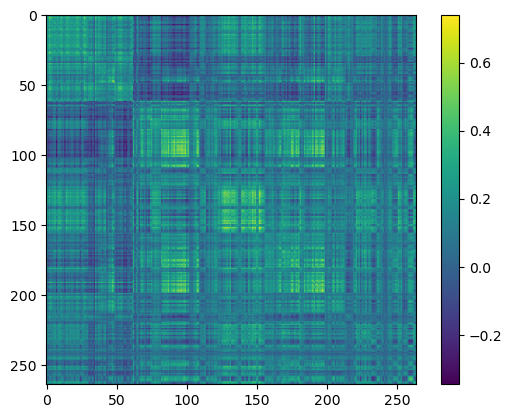

In [122]:
# Test sampling

import matplotlib.pyplot as plt

avg2 = None
idx = 200
n = 10000

with torch.no_grad():
    r = race[idx]
    s = sex[idx]
    a = (age[idx]-np.mean(age))/np.std(age)
    zz = vae.gen(n)
    z = zsnp[np.ones(n)*idx]
    sims = sim(zz, z).reshape(-1)
    idcs = torch.argsort(sims, descending=True)
    ones = torch.ones(100).float().cuda()
    xx = vae.dec(zz[idcs[:100]], a*ones, s*ones, r*ones, 1*ones, 0*ones, 0*ones)
    xx = xx.detach().cpu().numpy()
    xx[xx > 1] = 1
    avg2 = np.mean(xx, axis=0)

plt.imshow(xx[0])
plt.colorbar()
plt.show()

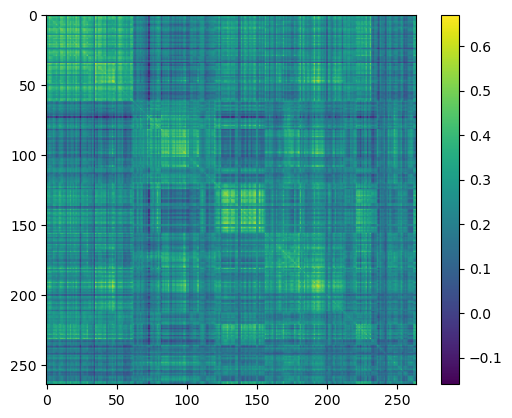

In [127]:
plt.imshow(avg2)
plt.colorbar()
plt.show()

In [150]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1).fit(snps)
pcaz = pca.transform(snps)
print(np.mean(np.abs(pcaz),axis=0))
print(pca.inverse_transform(np.array([-20])))
print(snps[0])

[17.43921616]
[1.41101298 1.895795   0.94102689 ... 1.77254539 1.62490298 1.37582445]
[1. 2. 2. ... 1. 2. 1.]


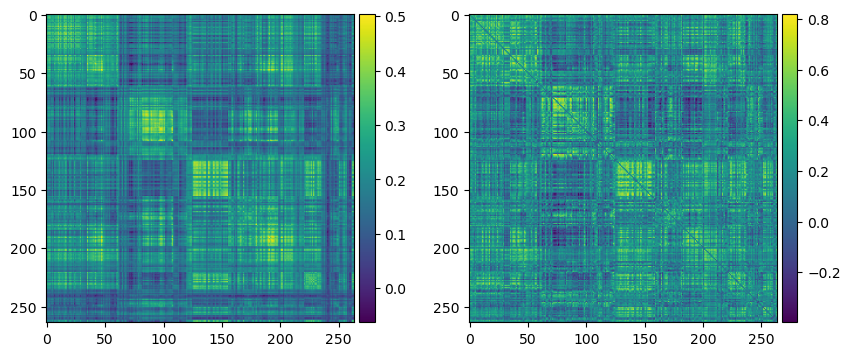

In [79]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

zeros = torch.zeros(len(z)).float().cuda()
ones = torch.ones(len(z)).float().cuda()
with torch.no_grad():
    noise = torch.randn(len(z), 30).float().cuda()*0
    resttest = vae.dec(z+noise, zeros, zeros, zeros, zeros, zeros, ones).detach().cpu().numpy()

fig, ax = plt.subplots(1,2,figsize=(10,4))

idx = 0

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)

im0 = ax[0].imshow(resttest[idx])

fig.colorbar(im0, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)

im1 = ax[1].imshow(emoidmat[idx])

fig.colorbar(im1, cax=cax, orientation='vertical')

fig.show()

In [9]:
import scipy.stats as stats

def corr(z, y):
    z = z - np.mean(z, axis=0, keepdims=True)
    y = y - np.mean(y)
    xx = np.einsum('na,na->a', z, z)
    yy = np.einsum('n,n->', y, y)
    xy = np.einsum('na,n->a', z, y)
    rho = xy/((xx*yy)**0.5)
    n = z.shape[0]
    m = z.shape[1]
    df = n-2
    t = rho*(df/(1-rho**2))**0.5
    t[t < 0] = -t[t < 0]
    p = (1-stats.t.cdf(t, df))*2
    p *= m
    p[p > 1] = 1
    return rho, p

def to_cat(y):
    cats = set()
    for yy in y:
        cats.add(yy)
    cats = list(cats)
    yp = np.zeros(len(y))
    for j,yy in enumerate(y):
        for i,cat in enumerate(cats):
            if yy == cat:
                yp[j] = i
    return yp

with torch.no_grad():
    zz = snpvae.enc(x).detach().cpu().numpy()

for key in pncdemo.keys():
    z = []
    y = []
    for i,sub in enumerate(subids):
        if sub in pncdemo[key]:
            z.append(zz[i])
            y.append(pncdemo[key][sub])
    if len(z) == 0:
        continue
    z = np.stack(z)
    y = np.array(y)
    if isinstance(y[0], str):
        y = to_cat(y)
    rho, p = corr(z, y)
    if np.any(p < 0.1):
        print(key, 'yes', p)

PADT_PC yes [1.         1.         1.         1.         0.19743768 1.
 1.         1.         0.61190228 1.         0.04189051 1.
 1.         1.         1.         1.         1.         1.
 0.13754691 1.         0.00742898 1.         1.         0.12654957
 1.         1.         1.         1.         0.02179638 1.        ]
PFMT_TP yes [1.         0.27416108 0.02361458 1.         1.         1.
 1.         1.         0.06148948 1.         0.97099897 1.
 1.         0.0342704  1.         1.         1.         1.
 1.         0.61398385 1.         1.         1.         1.
 1.         1.         0.02684454 1.         1.         1.        ]
PFMT_FN yes [1.         0.27416108 0.02361458 1.         1.         1.
 1.         1.         0.06148948 1.         0.97099897 1.
 1.         0.0342704  1.         1.         1.         1.
 1.         0.61398385 1.         1.         1.         1.
 1.         1.         0.02684454 1.         1.         1.        ]
PEIT_GENUS yes [1.         1.         1.    

/tmp/ipykernel_256199/1938030175.py:9: RuntimeWarning: invalid value encountered in divide
  rho = xy/((xx*yy)**0.5)
